<a href="https://colab.research.google.com/github/sgr1118/NLP_basic/blob/main/_2_%ED%85%8D%EC%8A%A4%ED%8A%B8_%EC%88%98%EC%A7%91_%EB%B0%8F_%ED%82%A4%EC%9B%8C%EB%93%9C_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 텍스트 수집 및 키워드 분석

## 한글 폰트 설정

* 실행 후 런타임 재시작 필요

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

%config InlineBackend.figure_format='retina'

!apt -qq -y install fonts-nanum

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


## 한국어 형태소 분석기 설치

* 한국어 자연어 처리 konlpy 라이브러리
* 형태소 분석기 MeCab 설치
* 설치 명령어: 
`!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash`

In [ ]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

## 키워드 분석(Keyword Analysis)

* 핵심어(keyword)란 텍스트 자료의 중요한 내용을 압축적으로 제시하는 단어 또는 문구
* 핵심어 분석이란 불용어 제거와 어간추출 및 형태소 분석 등의 자연어 처리를 시행한 후 텍스트에서 많이 등장하는 형태소의 등장 빈도를 분석함으로써 핵심어를 추출   
* 특정 텍스트 자료에 많이 나타나는 형태소가 그 텍스트 주제를 표출할 가능성이 높다는 가정에 기초  
* 물론 빈도 분석에서 영어의 전치사나 한국어의 조사와 같이 의미를 별로 담고 있지 않은 불용어는 제외하는 것이 좋음
* 키워드 분석은 텍스트의 주제 추정, 텍스트 유사도, 검색 엔진의 검색 결과 우선 순위 측정 등 다양하게 사용될 수 있음

### 네이버 영화 리뷰 데이터

* 키워드 분석에는 네이버 영화 리뷰 데이터를 사용
* 데이터 다운로드: https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt

In [2]:
import urllib.request

raw = urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt').readlines()

# 웹에있는 txt파일을 가져온다.

In [3]:
print(raw[:5])

[b'id\tdocument\tlabel\n', b'8112052\t\xec\x96\xb4\xeb\xa6\xb4\xeb\x95\x8c\xeb\xb3\xb4\xea\xb3\xa0 \xec\xa7\x80\xea\xb8\x88\xeb\x8b\xa4\xec\x8b\x9c\xeb\xb4\x90\xeb\x8f\x84 \xec\x9e\xac\xeb\xb0\x8c\xec\x96\xb4\xec\x9a\x94\xe3\x85\x8b\xe3\x85\x8b\t1\n', b'8132799\t\xeb\x94\x94\xec\x9e\x90\xec\x9d\xb8\xec\x9d\x84 \xeb\xb0\xb0\xec\x9a\xb0\xeb\x8a\x94 \xed\x95\x99\xec\x83\x9d\xec\x9c\xbc\xeb\xa1\x9c, \xec\x99\xb8\xea\xb5\xad\xeb\x94\x94\xec\x9e\x90\xec\x9d\xb4\xeb\x84\x88\xec\x99\x80 \xea\xb7\xb8\xeb\x93\xa4\xec\x9d\xb4 \xec\x9d\xbc\xea\xb5\xb0 \xec\xa0\x84\xed\x86\xb5\xec\x9d\x84 \xed\x86\xb5\xed\x95\xb4 \xeb\xb0\x9c\xec\xa0\x84\xed\x95\xb4\xea\xb0\x80\xeb\x8a\x94 \xeb\xac\xb8\xed\x99\x94\xec\x82\xb0\xec\x97\x85\xec\x9d\xb4 \xeb\xb6\x80\xeb\x9f\xac\xec\x9b\xa0\xeb\x8a\x94\xeb\x8d\xb0. \xec\x82\xac\xec\x8b\xa4 \xec\x9a\xb0\xeb\xa6\xac\xeb\x82\x98\xeb\x9d\xbc\xec\x97\x90\xec\x84\x9c\xeb\x8f\x84 \xea\xb7\xb8 \xec\x96\xb4\xeb\xa0\xa4\xec\x9a\xb4\xec\x8b\x9c\xec\xa0\x88\xec\x97\x90 \xeb\x81\x9d

* 데이터를 확인해보면 모두 바이트로 이루어져 있으며, 리뷰 외의 다른 데이터도 존재
* 데이터를 문자열로 변환하고 리뷰만 추출

In [4]:
raw = [x.decode() for x in raw[1:]] # id\tdocument\tlabel\n에서 id부터 필요하고 헤더 정보는 필요없기때문에 [1:]로 추출한다.

reviews = []
for i in raw:
    reviews.append(i.split('\t')[1]) # tab으로 나눠진 txt에서 document값을 가져온다.

print(reviews[:3])

['어릴때보고 지금다시봐도 재밌어요ㅋㅋ', '디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데. 사실 우리나라에서도 그 어려운시절에 끝까지 열정을 지킨 노라노 같은 전통이있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다.', '폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.']


### 형태소 분석을 이용한 명사 추출


* 형태소 분석기 Mecab으로 명사만 추출

In [5]:
from konlpy.tag import Mecab
tagger = Mecab()

reviews_nouns = []
for review in reviews:
    for noun in tagger.nouns(review):
        reviews_nouns.append(noun)

reviews_nouns[:3] # 불용어 제거해야할 필요가있다.

['때', '디자인', '학생']

#### 불용어(Stopwords) 사전 만들기

* 형태소 분석을 통해 조사, 접속사 등의 제거 가능
* 하지만 한국어는 명사에서도 상당히 많은 불필요한 단어들이 포함
* 사용자가 직접 불용어 사전을 유지하면서 불필요한 단어 제거 필요
* 불용어 예: `전 난 일 걸 뭐 줄 만 건 분 개 끝 잼 이거 번 중 듯 때 게 내 말 나 수 거 점 것 후 이 애 씨 속 뿐 밋 그 급 ㄷ 데`
* 빈도가 너무 커서 분석에 방해되는 단어도 제거 필요 (예: `영화`)


In [6]:
stop_words = '영화 전 난 일 걸 뭐 줄 만 건 분 개 끝 잼 이거 번 중 듯 때 게 내 말 나 수 거 점 것 후 이 애 씨 속 뿐 밋 그 급 ㄷ 데'
stop_words = stop_words.split(' ')
print(stop_words) 

['영화', '전', '난', '일', '걸', '뭐', '줄', '만', '건', '분', '개', '끝', '잼', '이거', '번', '중', '듯', '때', '게', '내', '말', '나', '수', '거', '점', '것', '후', '이', '애', '씨', '속', '뿐', '밋', '그', '급', 'ㄷ', '데']


#### 불용어를 제외하여 형태소 분석 수행

* 한글 텍스트에 대해서 형태소 분석 수행
* 분석으로 추출하는 명사 중에서 불용어에 포함되지 않은 텍스트만 추출하여 저장

In [7]:
reviews_nouns = []
for review in reviews:
    for noun in tagger.nouns(review):
        if noun not in stop_words:
            reviews_nouns.append(noun)

reviews_nouns[:3] # 불용어 제거 확인

['디자인', '학생', '외국']

### 단어 빈도수 측정

* 단어 빈도수 측정에는 `collections` 라이브러리의 `Counter` 함수를 이용
* `collections` 라이브러리는 내장 라이브러리로 별도 설치가 필요없음
* `counter`를 이용하면 각 단어와 각 단어의 빈도 수를 딕셔너리로 편리하게 생성 가능

In [8]:
from collections import Counter

reviews_nouns_counter = Counter(reviews_nouns)
top_reviews_nouns = dict(reviews_nouns_counter.most_common(100))
top_reviews_nouns # 추가적으로 불용어있는지 확인 할 수 있다.

{'연기': 9175,
 '최고': 8813,
 '평점': 8514,
 '스토리': 7163,
 '생각': 6943,
 '드라마': 6896,
 '사람': 6742,
 '감동': 6489,
 '배우': 5893,
 '내용': 5731,
 '감독': 5629,
 '재미': 5479,
 '시간': 5320,
 '년': 4936,
 '사랑': 4741,
 '쓰레기': 4585,
 '작품': 3985,
 '하나': 3923,
 '정도': 3656,
 '이건': 3650,
 '마지막': 3647,
 '액션': 3568,
 '기대': 3465,
 '장면': 3262,
 '이게': 3046,
 '편': 3044,
 '최악': 3019,
 '돈': 2980,
 '이야기': 2947,
 '이해': 2745,
 '명작': 2685,
 '여자': 2678,
 '이상': 2676,
 '처음': 2673,
 '한국': 2640,
 '주인공': 2553,
 '우리': 2531,
 '연출': 2376,
 '때문': 2371,
 '기억': 2364,
 '현실': 2193,
 '마음': 2128,
 '굿': 2110,
 '남자': 2078,
 '결말': 2066,
 '인생': 2060,
 '공포': 2048,
 '전개': 2035,
 '짜증': 2011,
 '소재': 1999,
 '느낌': 1950,
 '필요': 1929,
 '일본': 1878,
 '반전': 1868,
 '수준': 1864,
 '음악': 1852,
 '매력': 1832,
 '가슴': 1817,
 '인간': 1811,
 '짱': 1809,
 '아이': 1749,
 '원작': 1705,
 '눈물': 1704,
 '코미디': 1598,
 '추천': 1579,
 '자체': 1558,
 '실망': 1557,
 '대박': 1495,
 '눈': 1484,
 '몰입': 1453,
 '캐릭터': 1440,
 '나라': 1409,
 '가족': 1401,
 '건지': 1397,
 '연기력': 1387,
 '여운': 1386,
 '시리즈': 1

### 단어 빈도 시각화

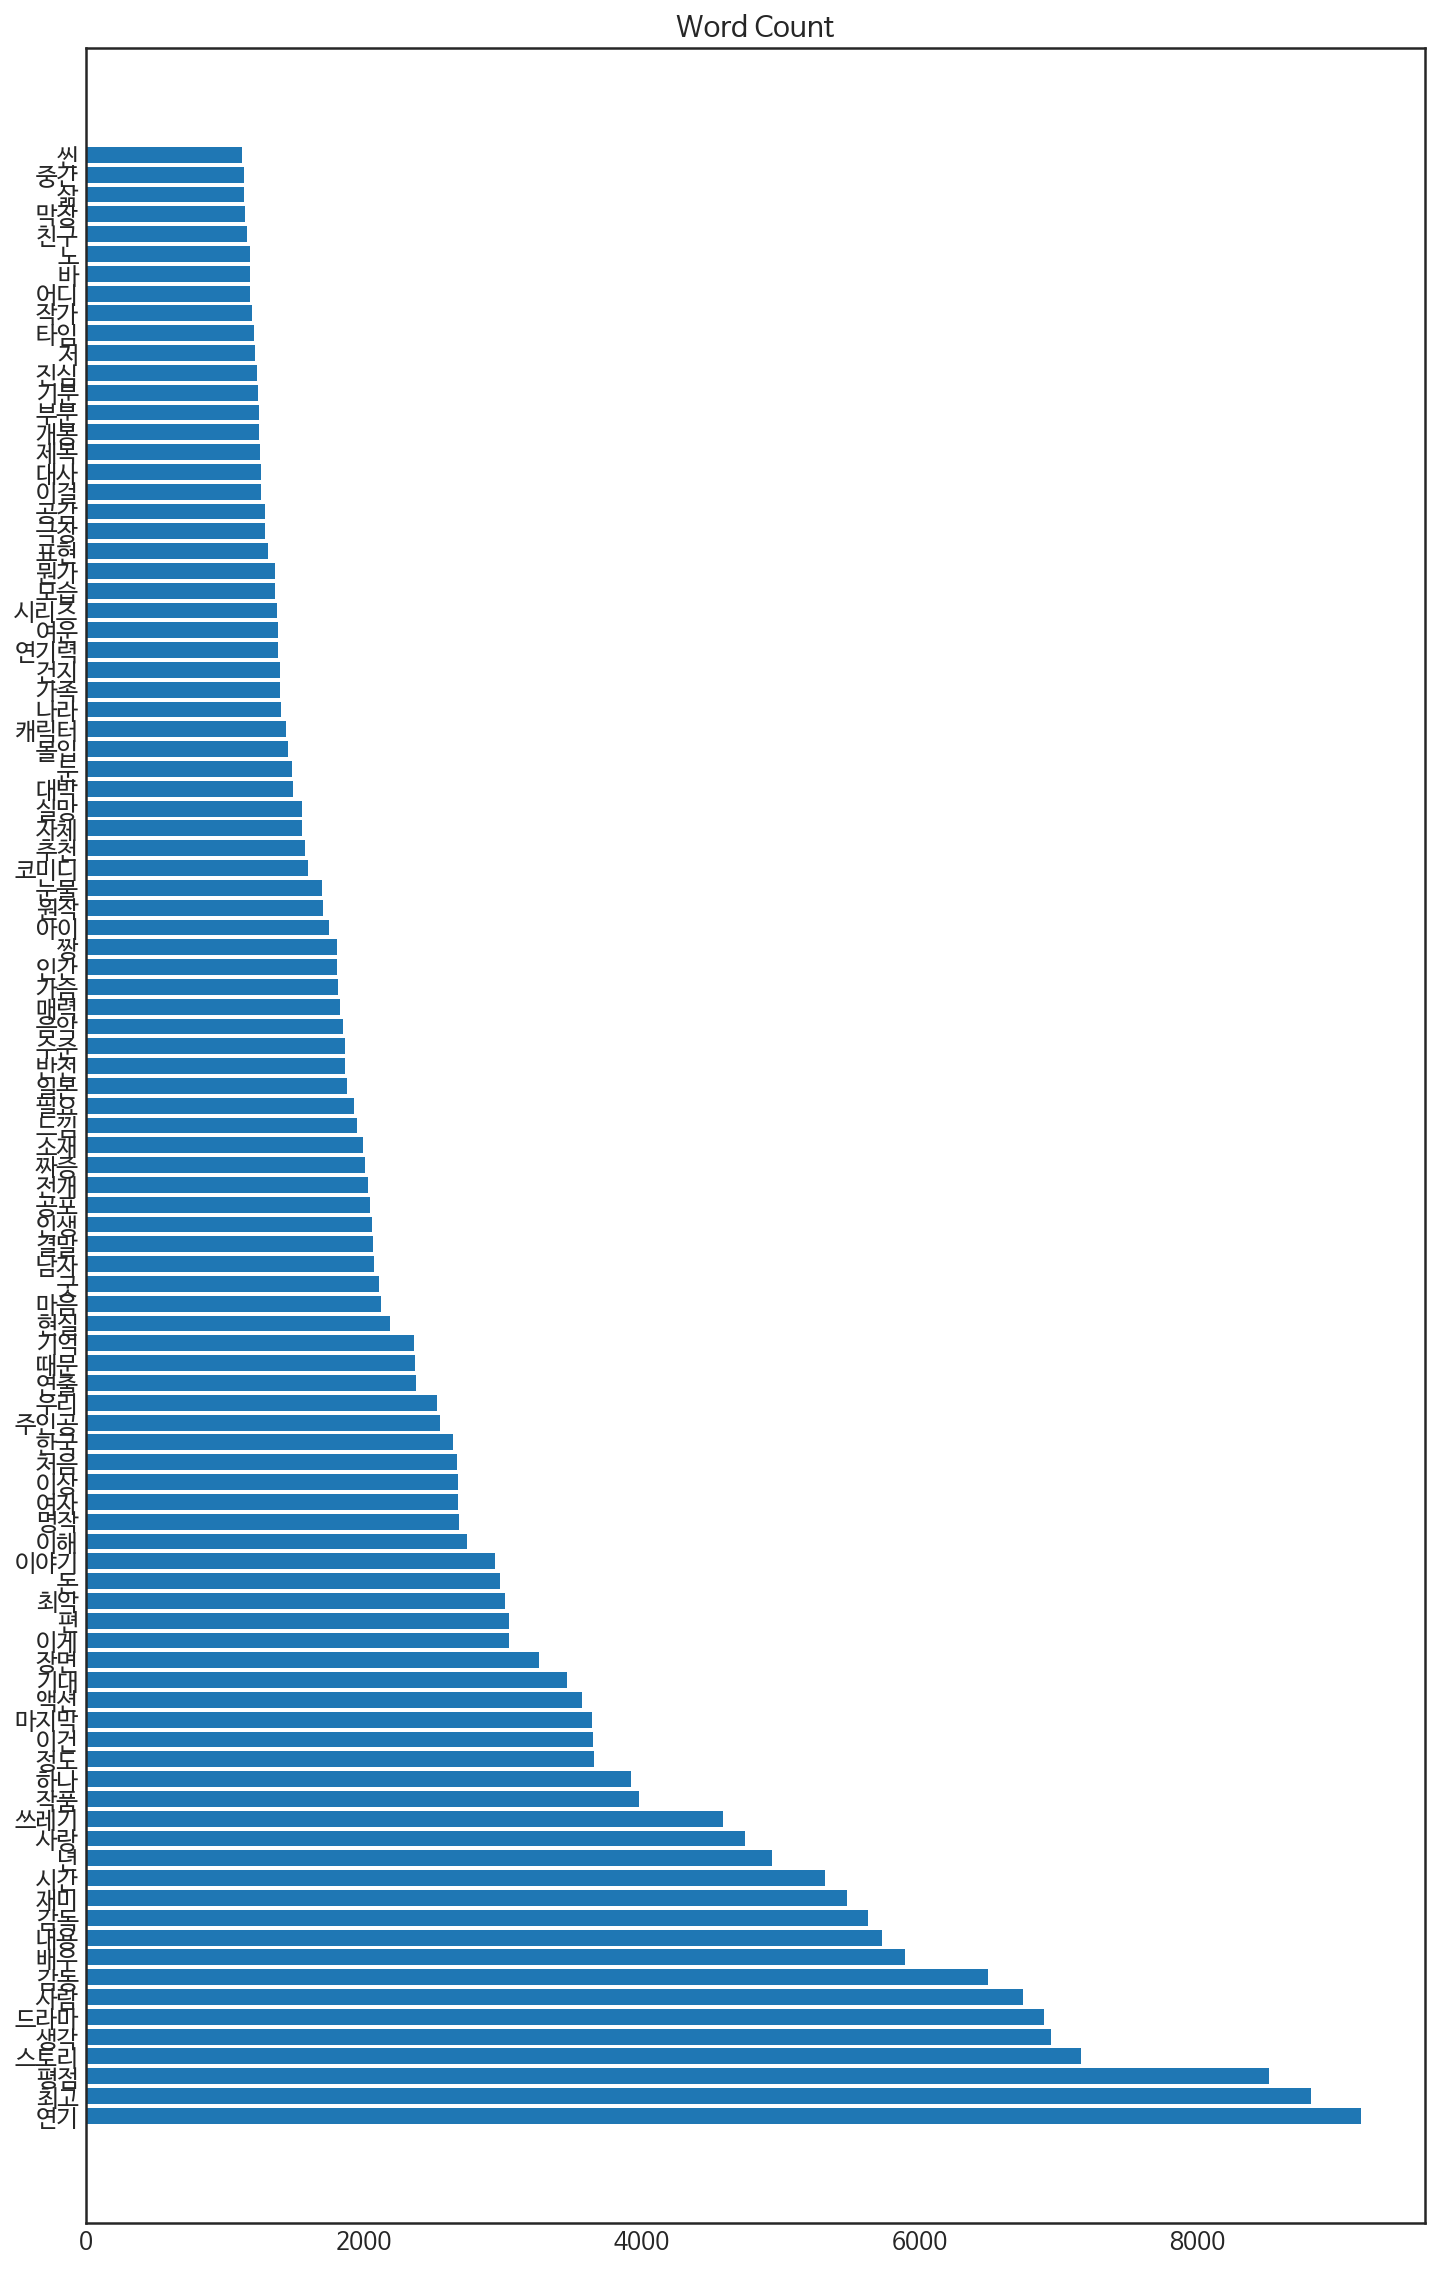

In [9]:
import numpy as np

plt.rcParams['font.size'] = 12

y_pos = np.arange(len(top_reviews_nouns))

plt.figure(figsize = (12, 20))
plt.barh(y_pos, top_reviews_nouns.values())
plt.title('Word Count')
plt.yticks(y_pos, top_reviews_nouns.keys())
plt.show() 

### 트리맵(Treemap) 시각화

* `squarify`는 트리맵 생성을 지원해주는 파이썬 라이브러리
* `squarify` 라이브러리를 이용해 키워드와 키워드 빈도 수를 트리맵으로 나타냄   

In [ ]:
!pip install squarify

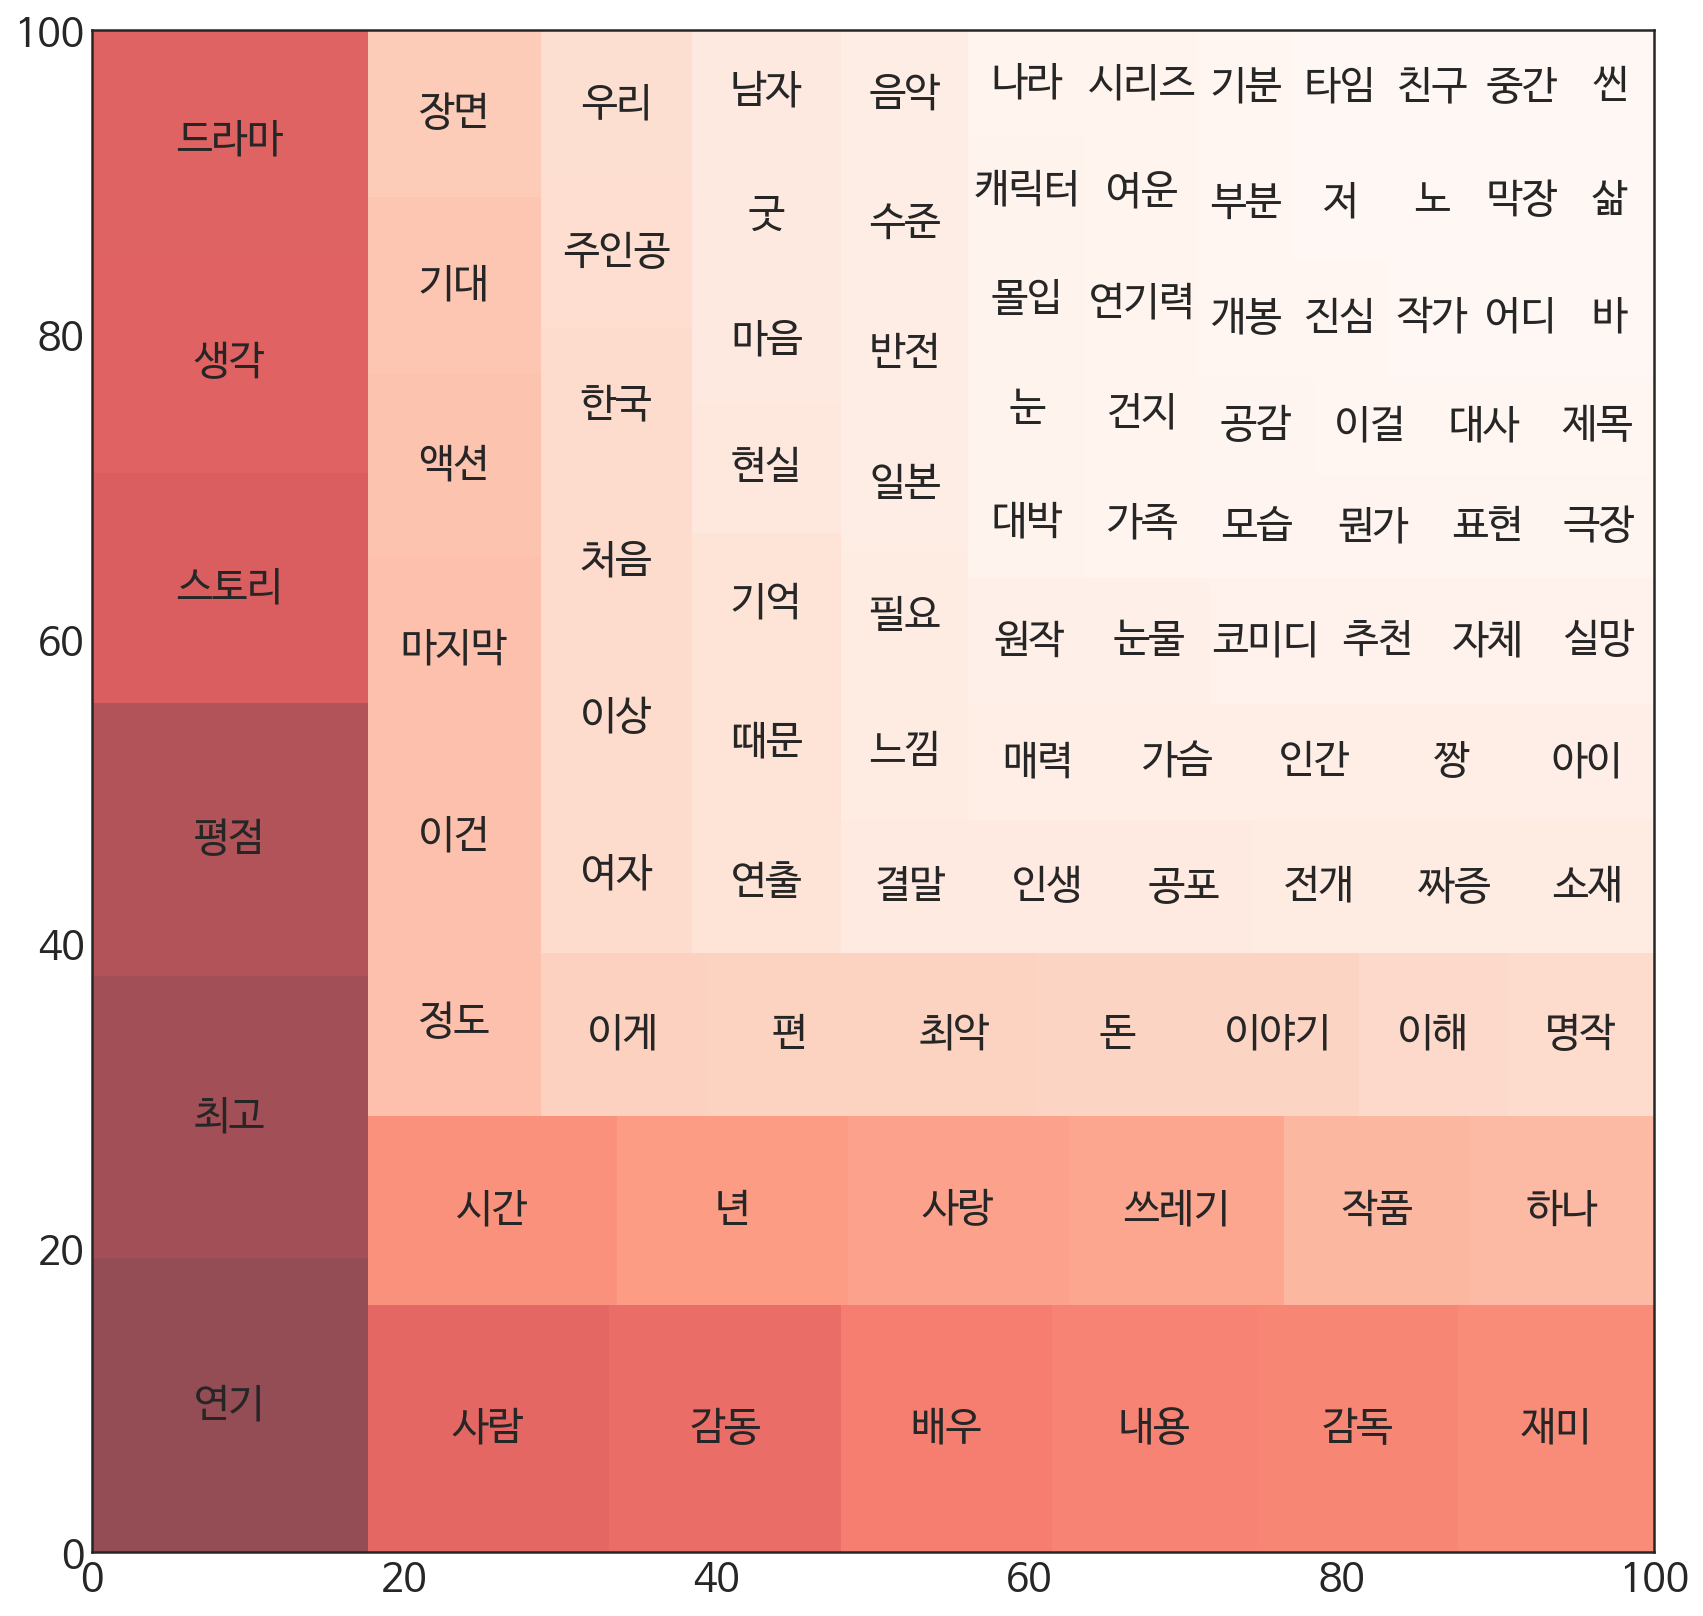

In [11]:
import squarify

plt.rcParams['figure.figsize'] = (14,14)
plt.rcParams['font.size'] = 20

norm = mpl.colors.Normalize(vmin = min(top_reviews_nouns.values()),
                            vmax = max(top_reviews_nouns.values())) # 색 범위를 고르게 만들기 위한 것이다.

colors = [mpl.cm.Reds(norm(value)) for value in top_reviews_nouns.values()]

squarify.plot(label = top_reviews_nouns.keys(),
              sizes = top_reviews_nouns.values(),
              color = colors,
              alpha = .7)

### 워드클라우드(WordCloud) 시각화

* 텍스트에 담겨있는 여러 형태소들의 등장 빈도를 가장 직관적으로 시각화하는 방법
* 텍스트에 등장하는 단어를 그 등장 빈도에 따라 서로 크기가 다르게 구름 형태로 표현함으로써, 단어의 빈도 수를 한번에 알 수 있음  
* 최근에 많은 서비스들이 어떤 핵심어가 많이 등장했는가를 워드클라우드 형식으로 시각화
* 빈도 수만을 시각적으로 표현한 것이기 때문에, 단어들 사이의 연관성이나 의미 구조 등을 분석하는 데는 한계가 있음

* 파이썬에서 워드 클라우드를 시각화하기 위해 `matplotlib` 라이브러리와 `WordCloud` 라이브러리를 `import` 해서 사용
* `WordCloud` 라이브러리는 `pip install wordcloud` 명령어를 통해 설치 필요

In [ ]:
!pip install wordcloud

* WordCloud를 이용해 객체를 생성해주고,
`generate_from_frequencies()` 함수로 빈도 수에 따라 워드클라우드 생성

In [14]:
from wordcloud import WordCloud

wc = WordCloud(background_color='black', font_path = './font/NanumBarunGothic.ttf')
wc.generate_from_frequencies(top_reviews_nouns) # 워드 클라우드 객체 생성

* 워드클라우드를 시각화할 때는 이미지 시각화 함수인 `imshow()` 함수를 사용해야 함

<function matplotlib.pyplot.show(*args, **kw)>

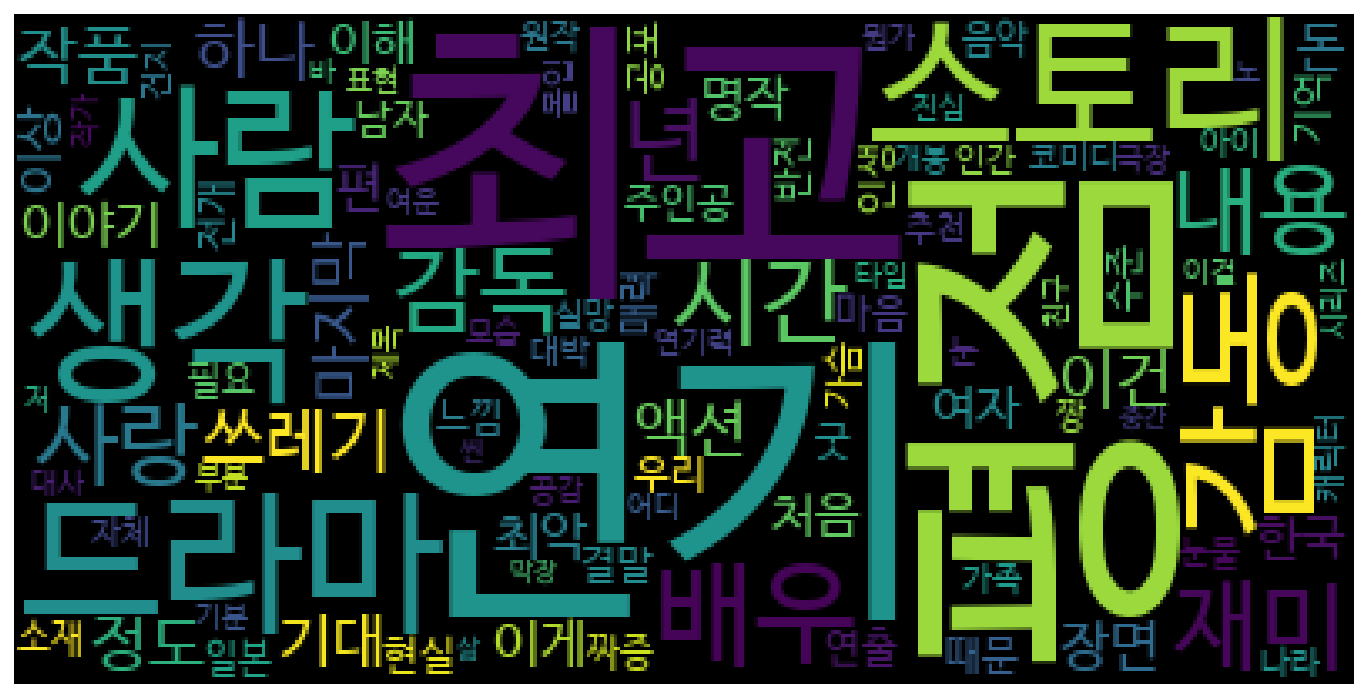

In [18]:
figure = plt.figure(figsize = (12,12))
ax = figure.add_subplot(1,1,1)
ax.axis('off') # 축제거
ax.imshow(wc)
plt.show

## 네이버 검색 API 서비스

### 네이버 서비스 API 신청

1. 네이버 개발자센터: https://developers.naver.com/
2. 어플리케이션 등록
3. 클라이언트 ID/SECRET 확인

### NAVER 서비스 API 종류

| 항목 | 주소                                         |
|------|----------------------------------------------|
|블로그| https://openapi.naver.com/v1/search/blog.json |
|뉴스　| https://openapi.naver.com/v1/search/news.json |
| 책　 | https://openapi.naver.com/v1/search/book.json|
| 성인 검색어 판별|　https://openapi.naver.com/v1/search/adult.json|
| 백과사전| https://openapi.naver.com/v1/search/encyc.json|
| 영화| https://openapi.naver.com/v1/search/movie.json|
| 카페글 |https://openapi.naver.com/v1/search/cafearticle.json|
| 지식in| https://openapi.naver.com/v1/search/kin.json|
| 지역 | https://openapi.naver.com/v1/search/local.json|
| 오타변환 | https://openapi.naver.com/v1/search/errata.json|
| 웹문서 | https://openapi.naver.com/v1/search/webkr.json|
| 이미지 | https://openapi.naver.com/v1/search/image.json|
| 쇼핑 | https://openapi.naver.com/v1/search/shop.json|
| 전문자료 | https://openapi.naver.com/v1/search/doc.json|

## 네이버 웹문서 키워드 분석

### 네이버 웹문서 검색 API

In [20]:
import os
import sys
import urllib.request
import pandas as pd
import json
import re

client_id = 'api_id' # 본인이 사용하는 api 아이디와 비밀번호를 사용하라
client_secret = 'api_secret'

query = urllib.parse.quote(input('검색 질의 : '))
idx = 0 
display = 100
start = 1
end = 1000 # 네이버가 한번에 검색할 때 나오는 양

web_df = pd.DataFrame(columns = ('Title', 'link', 'Description'))

for start_index in range(start, end, display):
    url = 'https://openapi.naver.com/v1/search/webkr?query=' + query \
    + '&display=' + str(display) + '&start=' + str(start_index)
    request = urllib.request.Request(url)
    request.add_header('X-Naver-Client-Id', client_id)
    request.add_header('X-Naver-Client-Secret', client_secret)
    response = urllib.request.urlopen(request)
    rescode = response.getcode() # 200이라는 코드가 와야 정상이다.

    if(rescode == 200):
        response_body = response.read()
        response_dict = json.loads(response_body.decode('utf-8'))
        items = response_dict['items']
        for item_index in range(0, len(items)):
            remove_tag = re.compile('<.*?>') # 특수문자 제거
            title = re.sub(remove_tag, '', items[item_index]['title']) # 태그를 제거하고 items안에 title을 가져온다.
            link = items[item_index]['link']
            description = re.sub(remove_tag, '', items[item_index]['description']) # 태그를 제거하고 items안에 description을 가져온다.
            web_df.loc[idx] = [title, link, description]
            idx += 1
    else:
        print('Error Code : ' + rescode)

web_df

검색 질의 : 인공지능


,Title,link,Description
0,인공지능 - 나무위키,https://namu.wiki/w/%EC%9D%B8%EA%B3%B5%EC%A7%8...,인공지능(人工知能) 또는 A.I.(Artificial Intelligence)는 일...
1,인공지능 - 해시넷,http://wiki.hash.kr/index.php/%EC%9D%B8%EA%B3%...,"인공지능(AI) 인공지능(人工知能, AI, artificial intelligenc..."
2,인공지능의 정의와 활용 방안 | SAS KOREA,https://www.sas.com/ko_kr/insights/analytics/w...,"SAS에서 인공지능(Artificial Intelligence)의 정의와 중요성, ..."
3,인공 지능(AI)이란? | 용어 해설 | HPE 대한민국,https://www.hpe.com/kr/ko/what-is/artificial-i...,AI(인공 지능)는 광범위하게 기계 또는 시스템이 하는 인간과 같은 모든 행동을 의...
4,바둑/인공지능 - 나무위키,https://namu.wiki/w/%EB%B0%94%EB%91%91/%EC%9D%...,지금까지 사용되었던 바둑프로그램의 인공지능을 요약하면 다음과 같다. 출처는 기사를 ...
...,...,...,...
145,책이 세상을 바꾼다 :: '인공지능' 태그의 글 목록,https://roadbook.co.kr/tag/%EC%9D%B8%EA%B3%B5%...,있습니다 인공지능과 추천 시스템은 동의어가 아닙니다 2장_ 선호도 조사 선호도 조사...
146,인공지능 - 아주대학교 | KOCW 공개 강의,http://www.kocw.net/home/cview.do?cid=4f101db7...,"아주대학교. 김민구. 인공지능 전반에 대한 소개와 지식표현, 추론 등을 중점적으로 ..."
147,테크라이브러리 - ITWorld Korea,https://www.itworld.co.kr/techlibrary/tag/1148...,뛰어난 인공지능(AI)을 만들려면 뛰어난 데이터가 뒷받침되어야... 인공지능 시장이...
148,인공지능 캐릭터 로봇 &lt;뽀로롯 미니&gt; | 와디즈 펀딩,https://www.wadiz.kr/web/campaign/detail/14232,"&lt;뽀로롯 미니&gt;는 대화,놀이,학습,일정 관리기능이 있는 국내 최초의 인공..."


In [21]:
web = []
for d in web_df.Description:
    web.append(d)

print(web[:3])

['인공지능(人工知能) 또는 A.I.(Artificial Intelligence)는 일반적으로 인간의 학습능력, 추론능력, 지각능력이 필요한 작업을 할 수 있도록 컴퓨터시스템을 구현하려는 컴퓨터과학의 세부분야 중 하나이다. 인간을 포함한 동물이 갖고 있는 지능 즉, natural intelligence와는 다른 개념이다.', '인공지능(AI) 인공지능(人工知能, AI, artificial intelligence)이란 인간처럼 학습하고 생각할 수 있는 컴퓨터 시스템을 말한다.', 'SAS에서 인공지능(Artificial Intelligence)의 정의와 중요성, AI의 역사와 활용 방법에 대해서 알아 보실 수 있습니다.']


### 형태소 분석을 이용한 명사 추출


#### 불용어 사전

불용어 예제: `인공지능 인공 지능 분야 수 것 등 기반 일 년 말 문 월 이 명 깨 개 중 범 부 딥 빅 책 분 봉 차 나 내 전 억 대 형 선 사 폼 원 번`

In [22]:
stop_words = '인공지능 인공 지능 분야 수 것 등 기반 일 년 말 문 월 이 명 깨 개 중 범 부 딥 빅 책 분 봉 차 나 내 전 억 대 형 선 사 폼 원 번'
stop_words = stop_words.split(' ')
print(stop_words)

['인공지능', '인공', '지능', '분야', '수', '것', '등', '기반', '일', '년', '말', '문', '월', '이', '명', '깨', '개', '중', '범', '부', '딥', '빅', '책', '분', '봉', '차', '나', '내', '전', '억', '대', '형', '선', '사', '폼', '원', '번']


In [23]:
tagger = Mecab()
web_nouns = []
for w in web:
    for noun in tagger.nouns(w):
        if noun not in stop_words:
            web_nouns.append(noun)

web_nouns[:10]

['人工', '知能', '일반', '인간', '학습', '능력', '추론', '능력', '지각', '능력']

### 단어 빈도수 측정

In [24]:
web_nouns_counter = Counter(web_nouns)
top_web_nouns = dict(web_nouns_counter.most_common(100))
top_web_nouns

{'기술': 46,
 '학습': 42,
 '컴퓨터': 34,
 '러닝': 33,
 '인간': 32,
 '문제': 29,
 '데이터': 21,
 '기계': 20,
 '능력': 19,
 '활용': 17,
 '로봇': 17,
 '시스템': 16,
 '이해': 16,
 '머신': 15,
 '미래': 15,
 '소개': 15,
 '과정': 15,
 '학과': 15,
 '방법': 14,
 '연구': 14,
 '과학': 13,
 '개념': 13,
 '서비스': 13,
 '산업': 13,
 '지식': 13,
 '기업': 12,
 '정보': 12,
 '사람': 12,
 '추론': 11,
 '분석': 11,
 '운영': 11,
 '발전': 10,
 '개발': 10,
 '제품': 10,
 '경험': 10,
 '교육': 10,
 '학창': 10,
 '시절': 10,
 '필요': 9,
 '솔루션': 9,
 '기능': 9,
 '시장': 9,
 '인식': 9,
 '구현': 8,
 '생각': 8,
 '기본': 8,
 '사례': 8,
 '윤리': 8,
 '지원': 8,
 '해결': 8,
 '소프트웨어': 8,
 '구축': 8,
 '전공': 8,
 '시간': 8,
 '월드': 8,
 '국내': 8,
 '비트': 8,
 '가능': 7,
 '시작': 7,
 '우리': 7,
 '제공': 7,
 '표현': 7,
 '봇': 7,
 '처리': 7,
 '테크': 7,
 '때': 7,
 '대학교': 7,
 '금융': 7,
 '보안': 7,
 '知能': 6,
 '역사': 6,
 '한국': 6,
 '강화': 6,
 '신경망': 6,
 '모델': 6,
 '조사': 6,
 '진화': 6,
 '법': 6,
 '자율': 6,
 '학사': 6,
 '학위': 6,
 '추천': 6,
 '챗': 6,
 '최신': 6,
 '원리': 6,
 '이론': 6,
 '융합': 6,
 '관련': 6,
 '실습': 6,
 '상품': 6,
 '수업': 6,
 '테스트': 6,
 '정리': 6,
 '최근': 6,
 '人工': 5,
 '정의'

### 단어 빈도 시각화

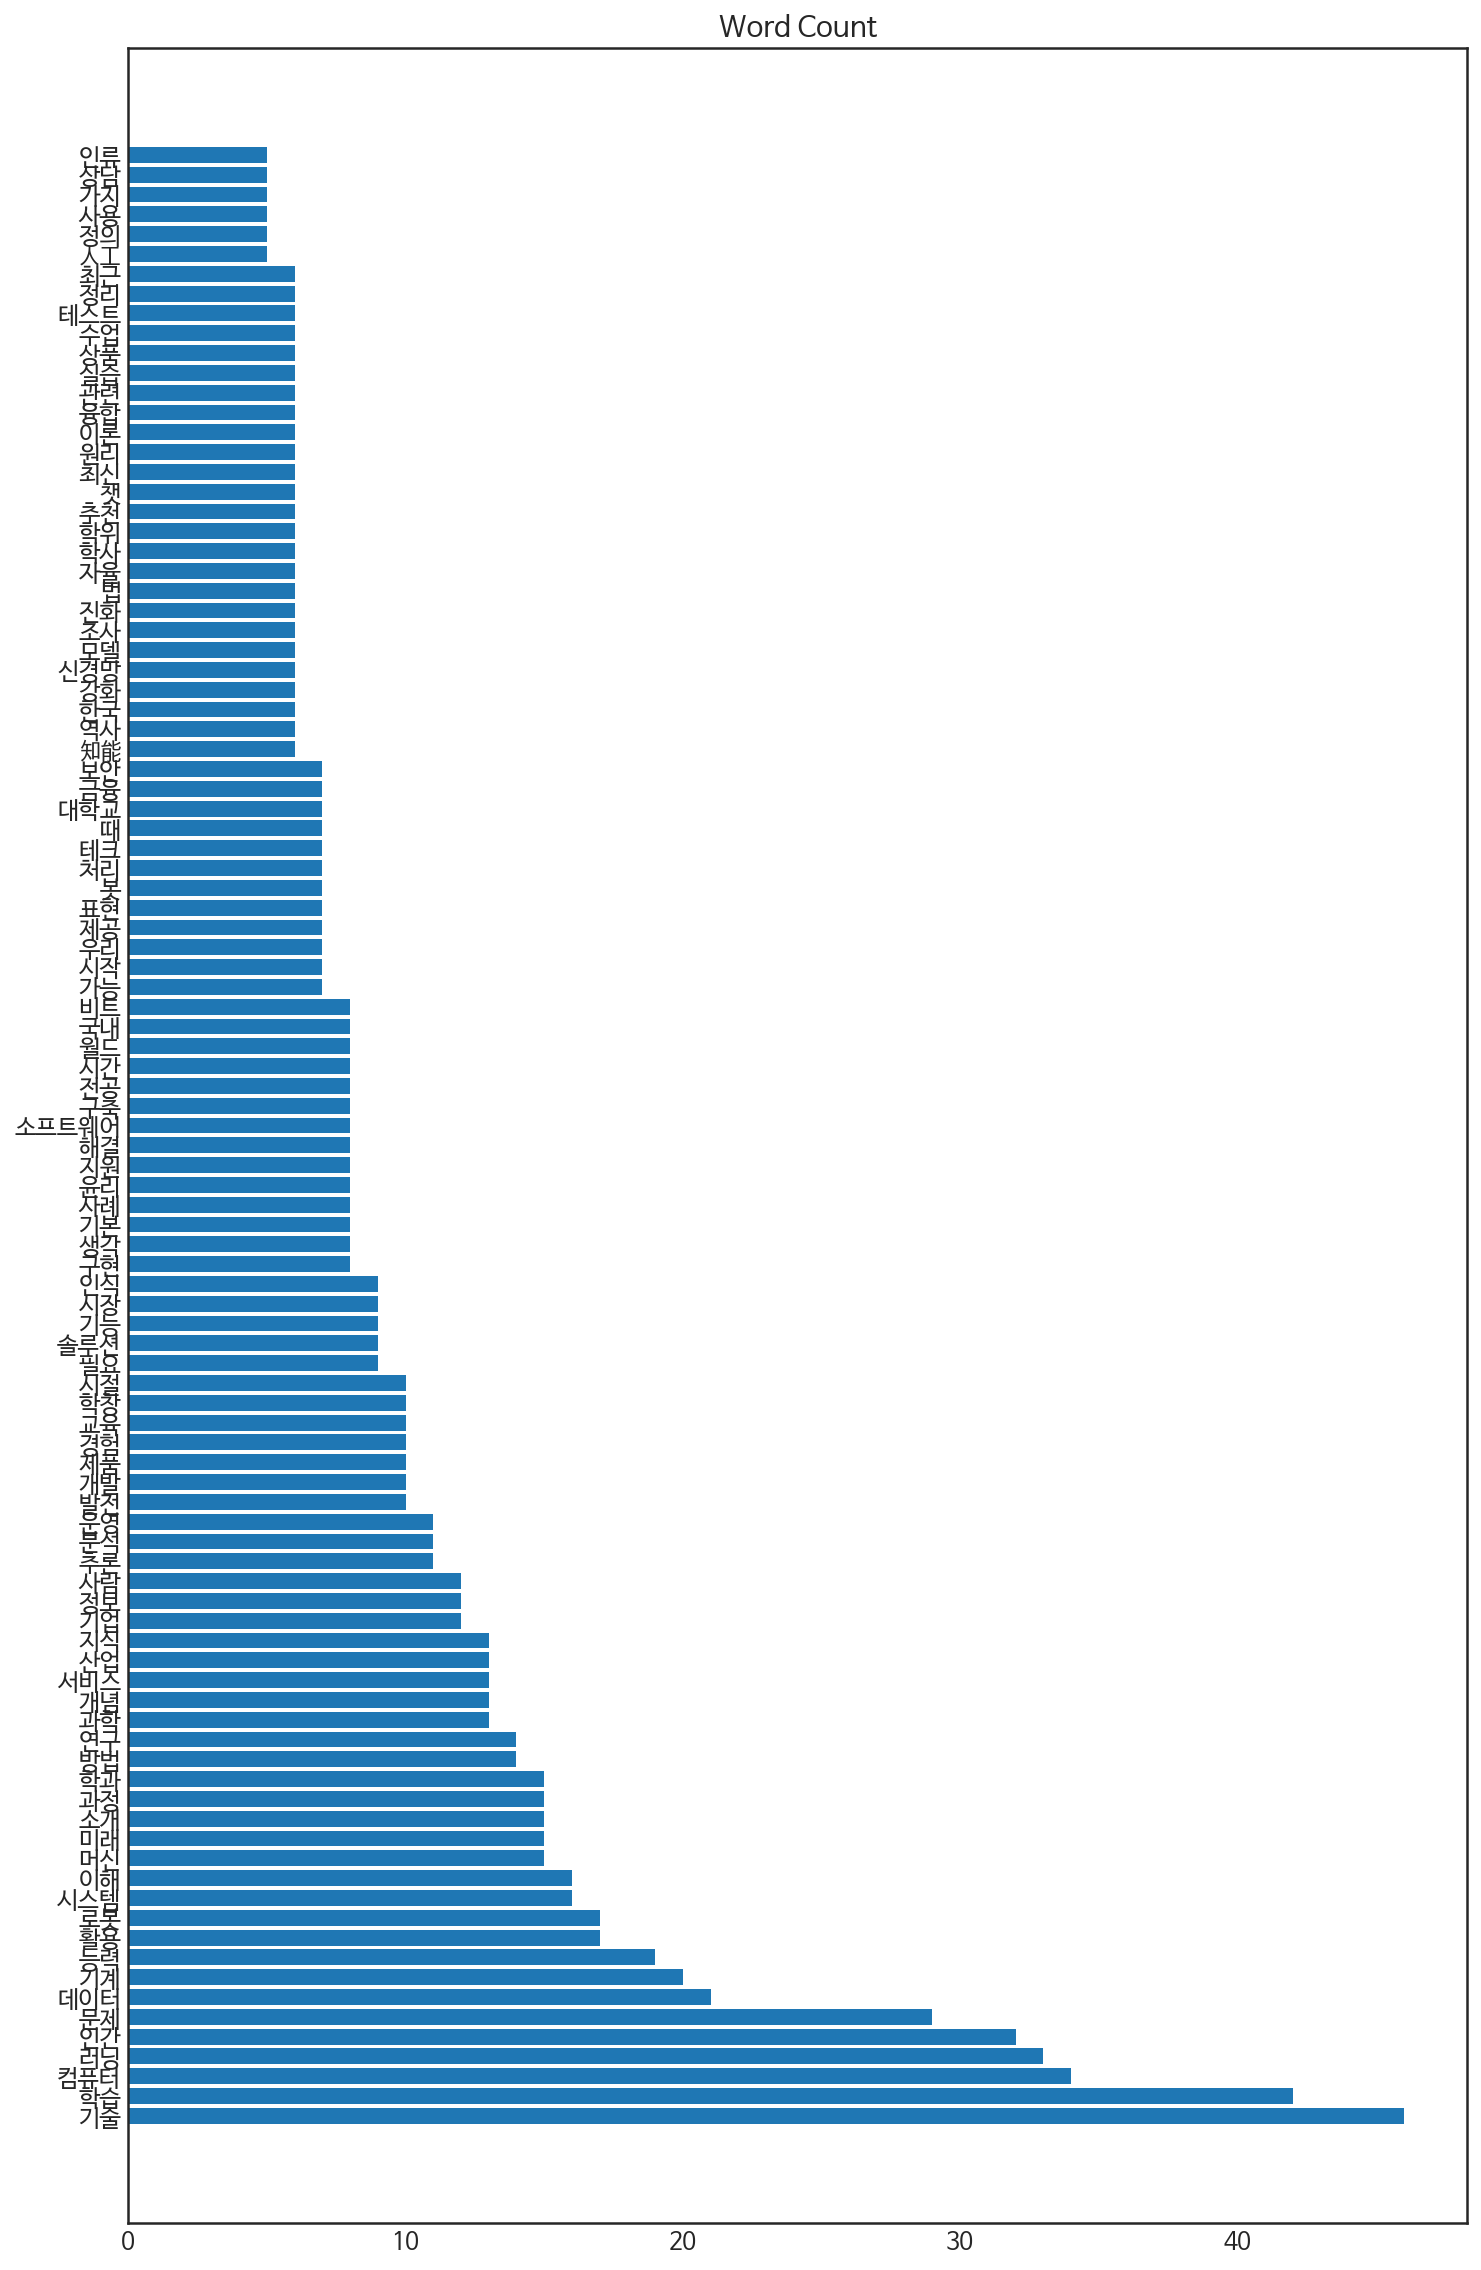

In [25]:
import numpy as np

plt.rcParams['font.size'] = 12

y_pos = np.arange(len(top_web_nouns))

plt.figure(figsize = (12, 20))
plt.barh(y_pos, top_web_nouns.values())
plt.title('Word Count')
plt.yticks(y_pos, top_web_nouns.keys())
plt.show() 

### 트리맵 시각화

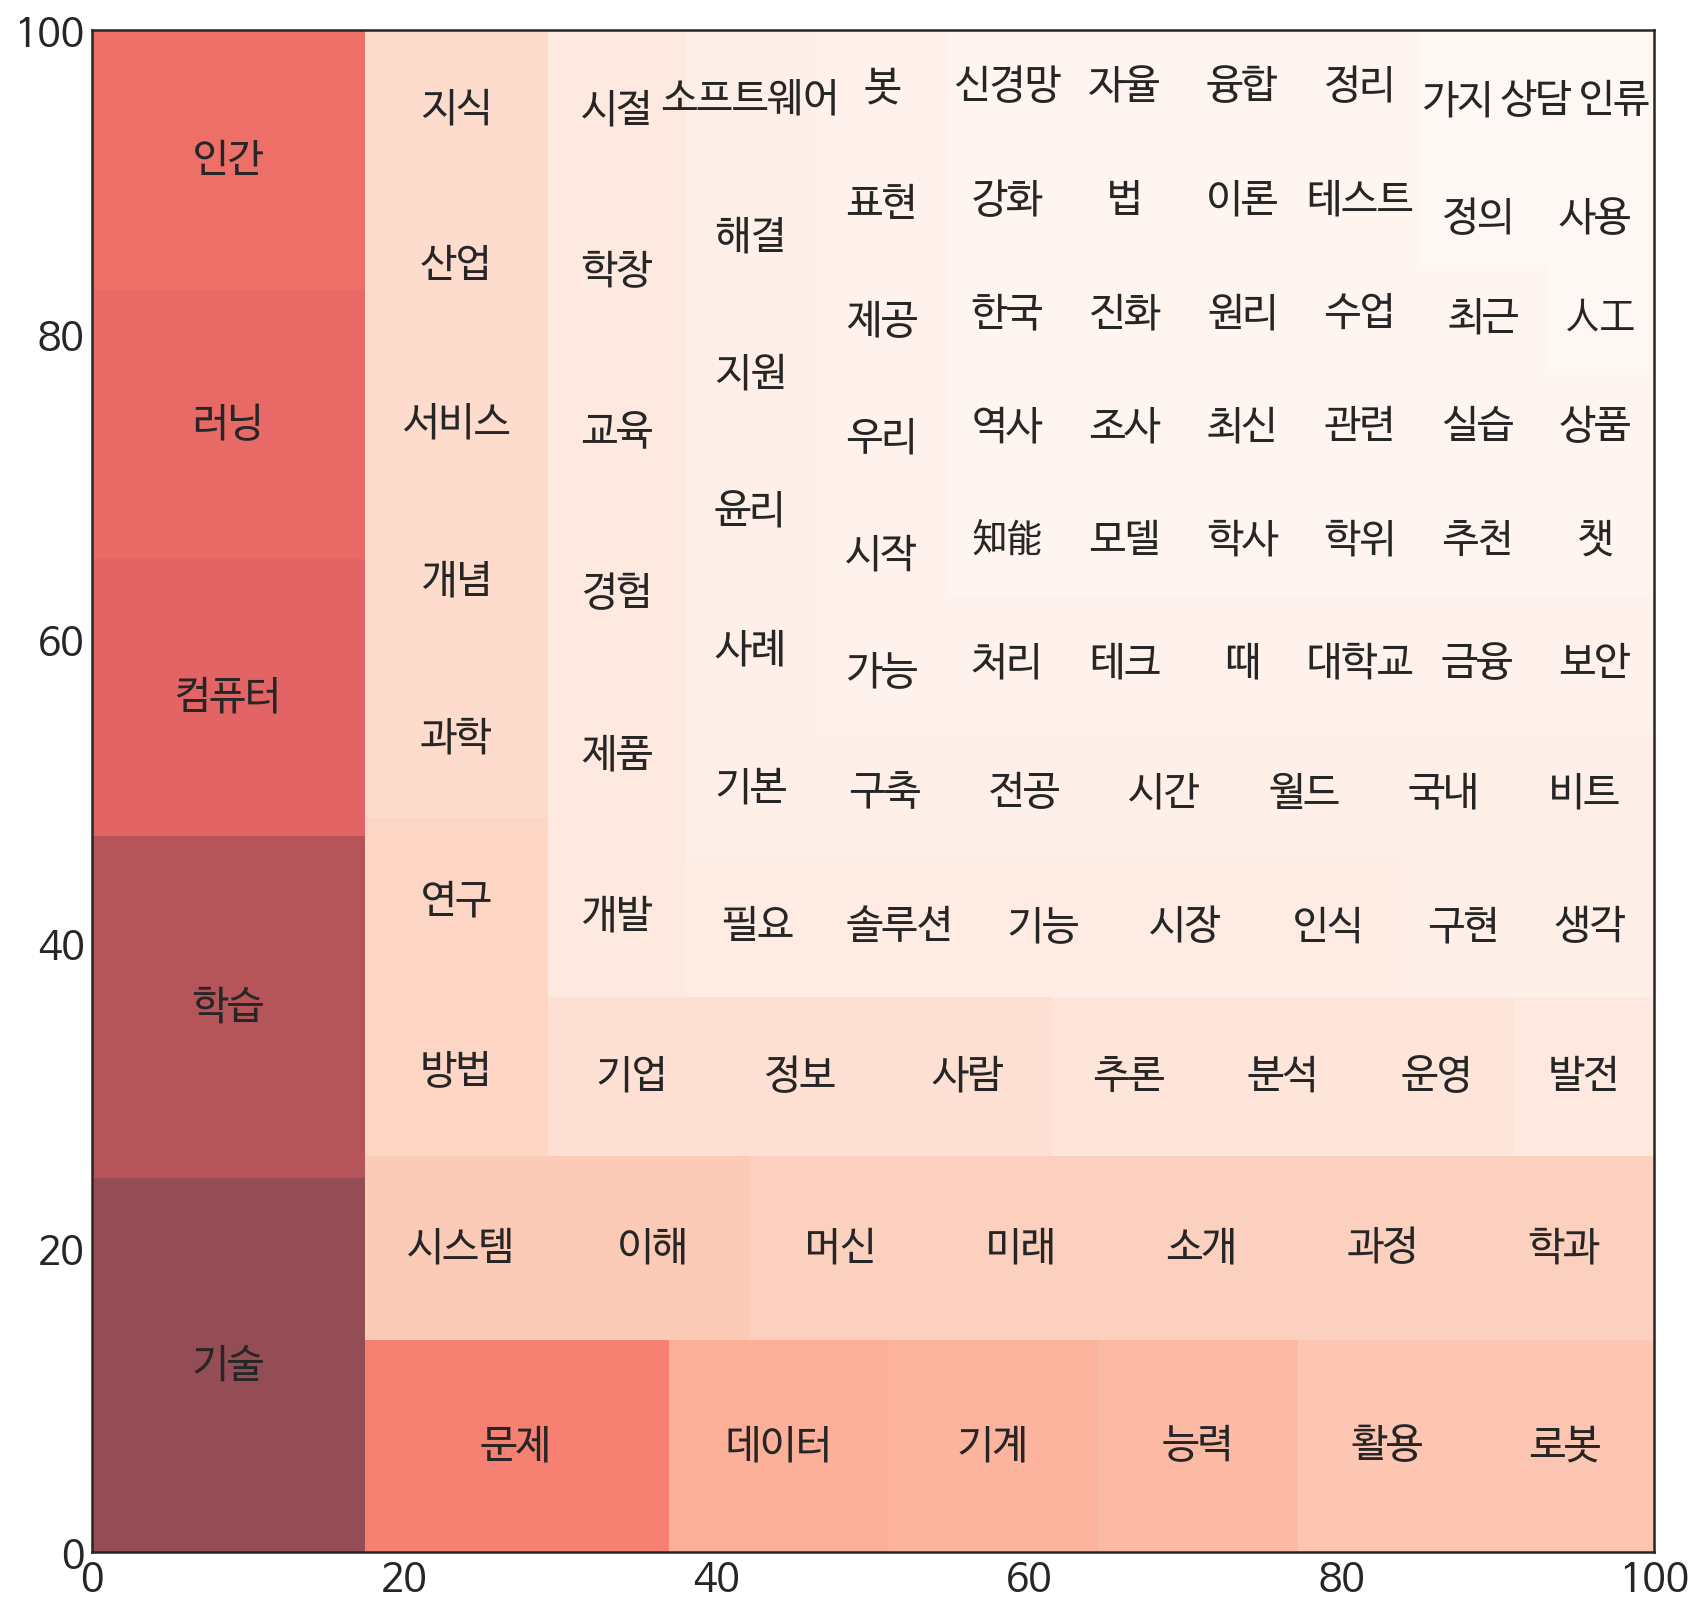

In [27]:
plt.rcParams['figure.figsize'] = (14,14)
plt.rcParams['font.size'] = 20

norm = mpl.colors.Normalize(vmin = min(top_web_nouns.values()),
                            vmax = max(top_web_nouns.values()))

colors = [mpl.cm.Reds(norm(value)) for value in top_web_nouns.values()]

squarify.plot(label = top_web_nouns.keys(),
              sizes = top_web_nouns.values(),
              color = colors,
              alpha = .7)

### 워드클라우드 시각화

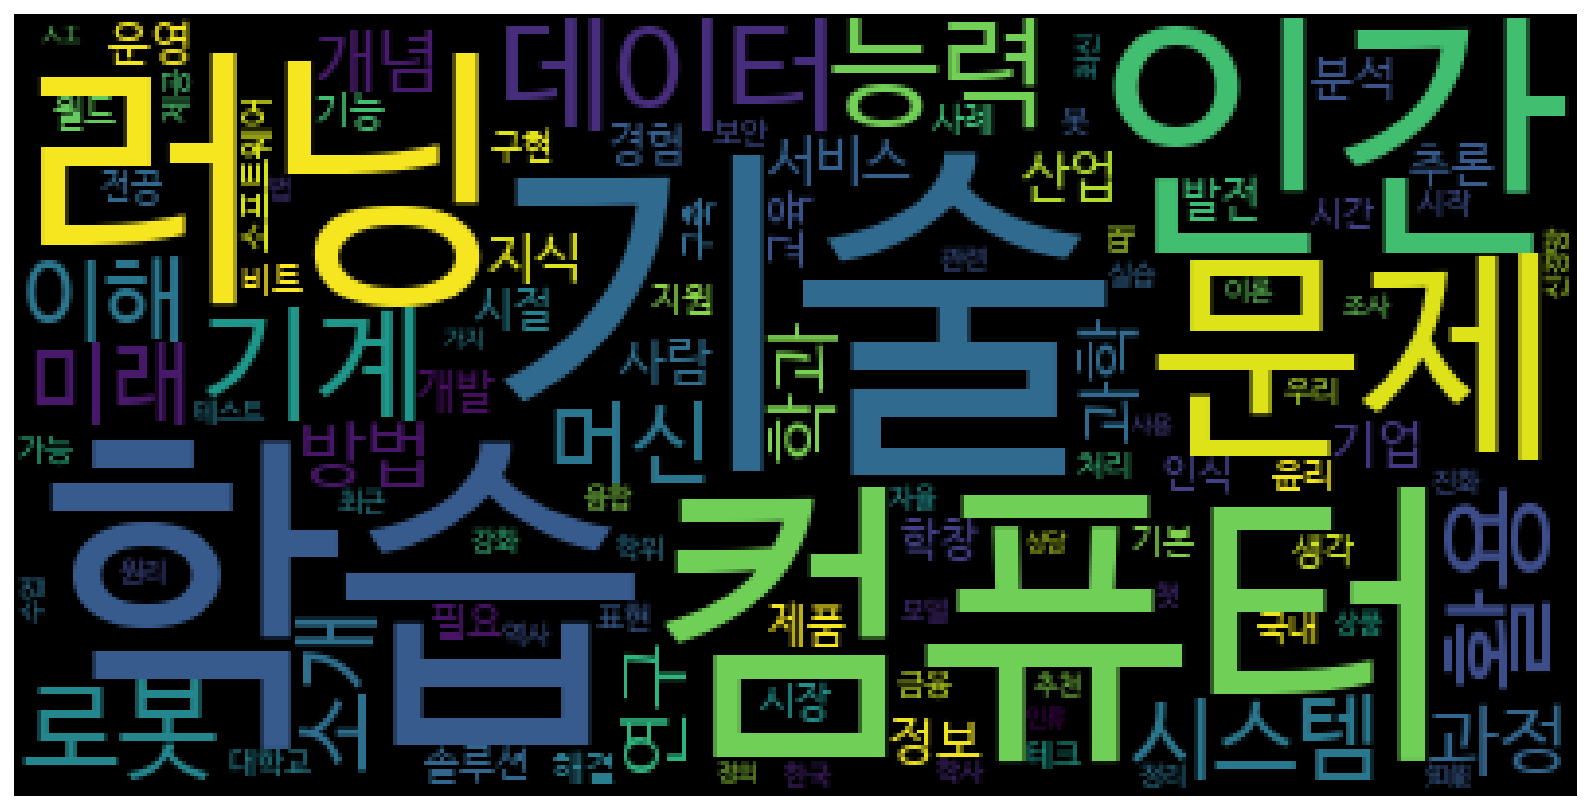

In [29]:
wc = WordCloud(background_color = 'black', font_path = './font/NanumBarunGothic.ttf')
wc.generate_from_frequencies(top_web_nouns)

figure = plt.figure(figsize = (14,14))
ax = figure.add_subplot(1,1,1)
ax.axis('off')
ax.imshow(wc)
plt.show()

## 네이버 뉴스 키워드 분석

### 네이버 뉴스 검색 API

In [30]:
import os
import sys
import urllib.request
import pandas as pd
import json
import re

client_id = 'api_id' # 본인이 사용하는 api 아이디와 비밀번호를 사용하라
client_secret = 'api_secret'

query = urllib.parse.quote(input('검색 질의 : '))
idx = 0 
display = 100
start = 1
end = 1000 # 네이버가 한번에 검색할 때 나오는 양
sort = 'sim'
news_df = pd.DataFrame(columns = ('Title', 'Original Link','link', 'Description', 'Publication Date'))

for start_index in range(start, end, display):
    url = 'https://openapi.naver.com/v1/search/news?query=' + query \
    + '&display=' + str(display) + '&start=' + str(start_index) + '&sort=' + sort
    request = urllib.request.Request(url)
    request.add_header('X-Naver-Client-Id', client_id)
    request.add_header('X-Naver-Client-Secret', client_secret)
    response = urllib.request.urlopen(request)
    rescode = response.getcode() 

    if(rescode == 200): # 200이라는 코드가 와야 정상이다.
        response_body = response.read()
        response_dict = json.loads(response_body.decode('utf-8'))
        items = response_dict['items']
        for item_index in range(0, len(items)):
            remove_tag = re.compile('<.*?>') # 특수문자 제거
            title = re.sub(remove_tag, '', items[item_index]['title']) # 태그를 제거하고 items안에 title을 가져온다.
            original_link = items[item_index]['originallink']
            link = items[item_index]['link']
            description = re.sub(remove_tag, '', items[item_index]['description']) # 태그를 제거하고 items안에 description을 가져온다.
            pub_date = items[item_index]['pubDate']
            news_df.loc[idx] = [title, original_link, link, description, pub_date]
            idx += 1
    else:
        print('Error Code : ' + rescode)

news_df

검색 질의 : 인공지능


,Title,Original Link,link,Description,Publication Date
0,"국가기술표준원, 자율주행·인공지능 등 핵심 기술 표준화 작업",https://www.nocutnews.co.kr/news/5876298,https://n.news.naver.com/mnews/article/079/000...,핵심요약 2023년 디지털 전환 원년…수출 지원과 신시장 창출 목표 우리나라 첨단 ...,"Sun, 08 Jan 2023 12:17:00 +0900"
1,패션 산업의 미래...인공지능 활용 디자인,https://www.ytn.co.kr/_ln/0104_202301081442077758,https://n.news.naver.com/mnews/article/052/000...,"인공지능 AI는 대화형 챗봇은 물론 기사작성, 자율 주행 등 다양한 분야에 활용되고...","Sun, 08 Jan 2023 14:42:00 +0900"
2,"음성 소이초, 소프트웨어·인공지능 교육캠프 운영",https://www.ccdailynews.com/news/articleView.h...,https://www.ccdailynews.com/news/articleView.h...,이번 AI교육 캠프는 전국 단위로 처음 실시되는 방학 중 소프트웨어·인공지능교육 캠...,"Sun, 08 Jan 2023 22:16:00 +0900"
3,"국표원, 자율주행·인공지능 등 핵심 기술 표준화 추진",https://www.electimes.com/news/articleView.htm...,https://www.electimes.com/news/articleView.htm...,"정부가 수출과 신시장 창출을 위해 자율주행, 인공지능(AI), 반도체와 같은 디지털...","Sun, 08 Jan 2023 12:54:00 +0900"
4,"유영상 사장, AI컴퍼니 도약 위한 글로벌 인공지능 초협력 광폭 행보",https://www.aitimes.kr/news/articleView.html?i...,https://www.aitimes.kr/news/articleView.html?i...,총출동해 인공지능(AI) 기업들을 잇따라 만나며 AI 컴퍼니 도약을 위한 초협력 광...,"Sun, 08 Jan 2023 12:30:00 +0900"
...,...,...,...,...,...
995,"KAIST, 2022 스타트업 페스티벌 개최...인공지능, 디지털트윈 등 창업기업 ...",https://www.aitimes.kr/news/articleView.html?i...,https://www.aitimes.kr/news/articleView.html?i...,KAIST는 ▷나니아랩스(제조 분야 인공지능 솔루션) ▷임팩트 AI(인공지능·빅데이...,"Mon, 12 Dec 2022 11:14:00 +0900"
996,"광주인공지능사관학교, 인공지능(AI) 전문가 302명 배출",https://www.jeonmae.co.kr/news/articleView.htm...,https://www.jeonmae.co.kr/news/articleView.htm...,3기 광주인공지능사관학교(이하 사관학교)가 302명의 인공지능(AI) 전문 인재를 ...,"Fri, 16 Dec 2022 19:36:00 +0900"
997,인공지능 도움으로 삶의 질 높인다...AI기반 서비스 앱 4PICK,http://www.slist.kr/news/articleView.html?idxn...,http://www.slist.kr/news/articleView.html?idxn...,"인공지능(AI)이 날씨 정보를 알려주고, 메시지도 자동으로 전송해주는 시대다. 실생...","Mon, 19 Dec 2022 15:16:00 +0900"
998,"네이버 커넥트재단, 초등학생 대상 인공지능 교육캠프 &apos;1784 스쿨혁명&a...",http://www.digitaltoday.co.kr/news/articleView...,http://www.digitaltoday.co.kr/news/articleView...,"네이버 커넥트재단, 초등학생 대상 인공지능 교육캠프 &apos;1784 스쿨혁명&a...","Mon, 12 Dec 2022 15:02:00 +0900"


In [31]:
news = []
for n in news_df.Title:
    news.append(n)

print(news[:5])

['국가기술표준원, 자율주행·인공지능 등 핵심 기술 표준화 작업', '패션 산업의 미래...인공지능 활용 디자인', '음성 소이초, 소프트웨어·인공지능 교육캠프 운영', '국표원, 자율주행·인공지능 등 핵심 기술 표준화 추진', '유영상 사장, AI컴퍼니 도약 위한 글로벌 인공지능 초협력 광폭 행보']


### 형태소 분석을 이용한 명사 추출


In [33]:
tagger = Mecab()
news_nouns = []
for n in news:
    for noun in tagger.nouns(n):
        if noun not in stop_words:
            news_nouns.append(noun)

news_nouns[:10]

['국가', '기술', '표', '준원', '자율', '주행', '핵심', '기술', '표준', '작업']

### 단어 빈도수 측정

In [ ]:
news_nouns_conter = Counter(news_nouns)
top_news_nouns = dict(news_nouns_conter.most_common(100))
top_news_nouns

### 단어 빈도 시각화

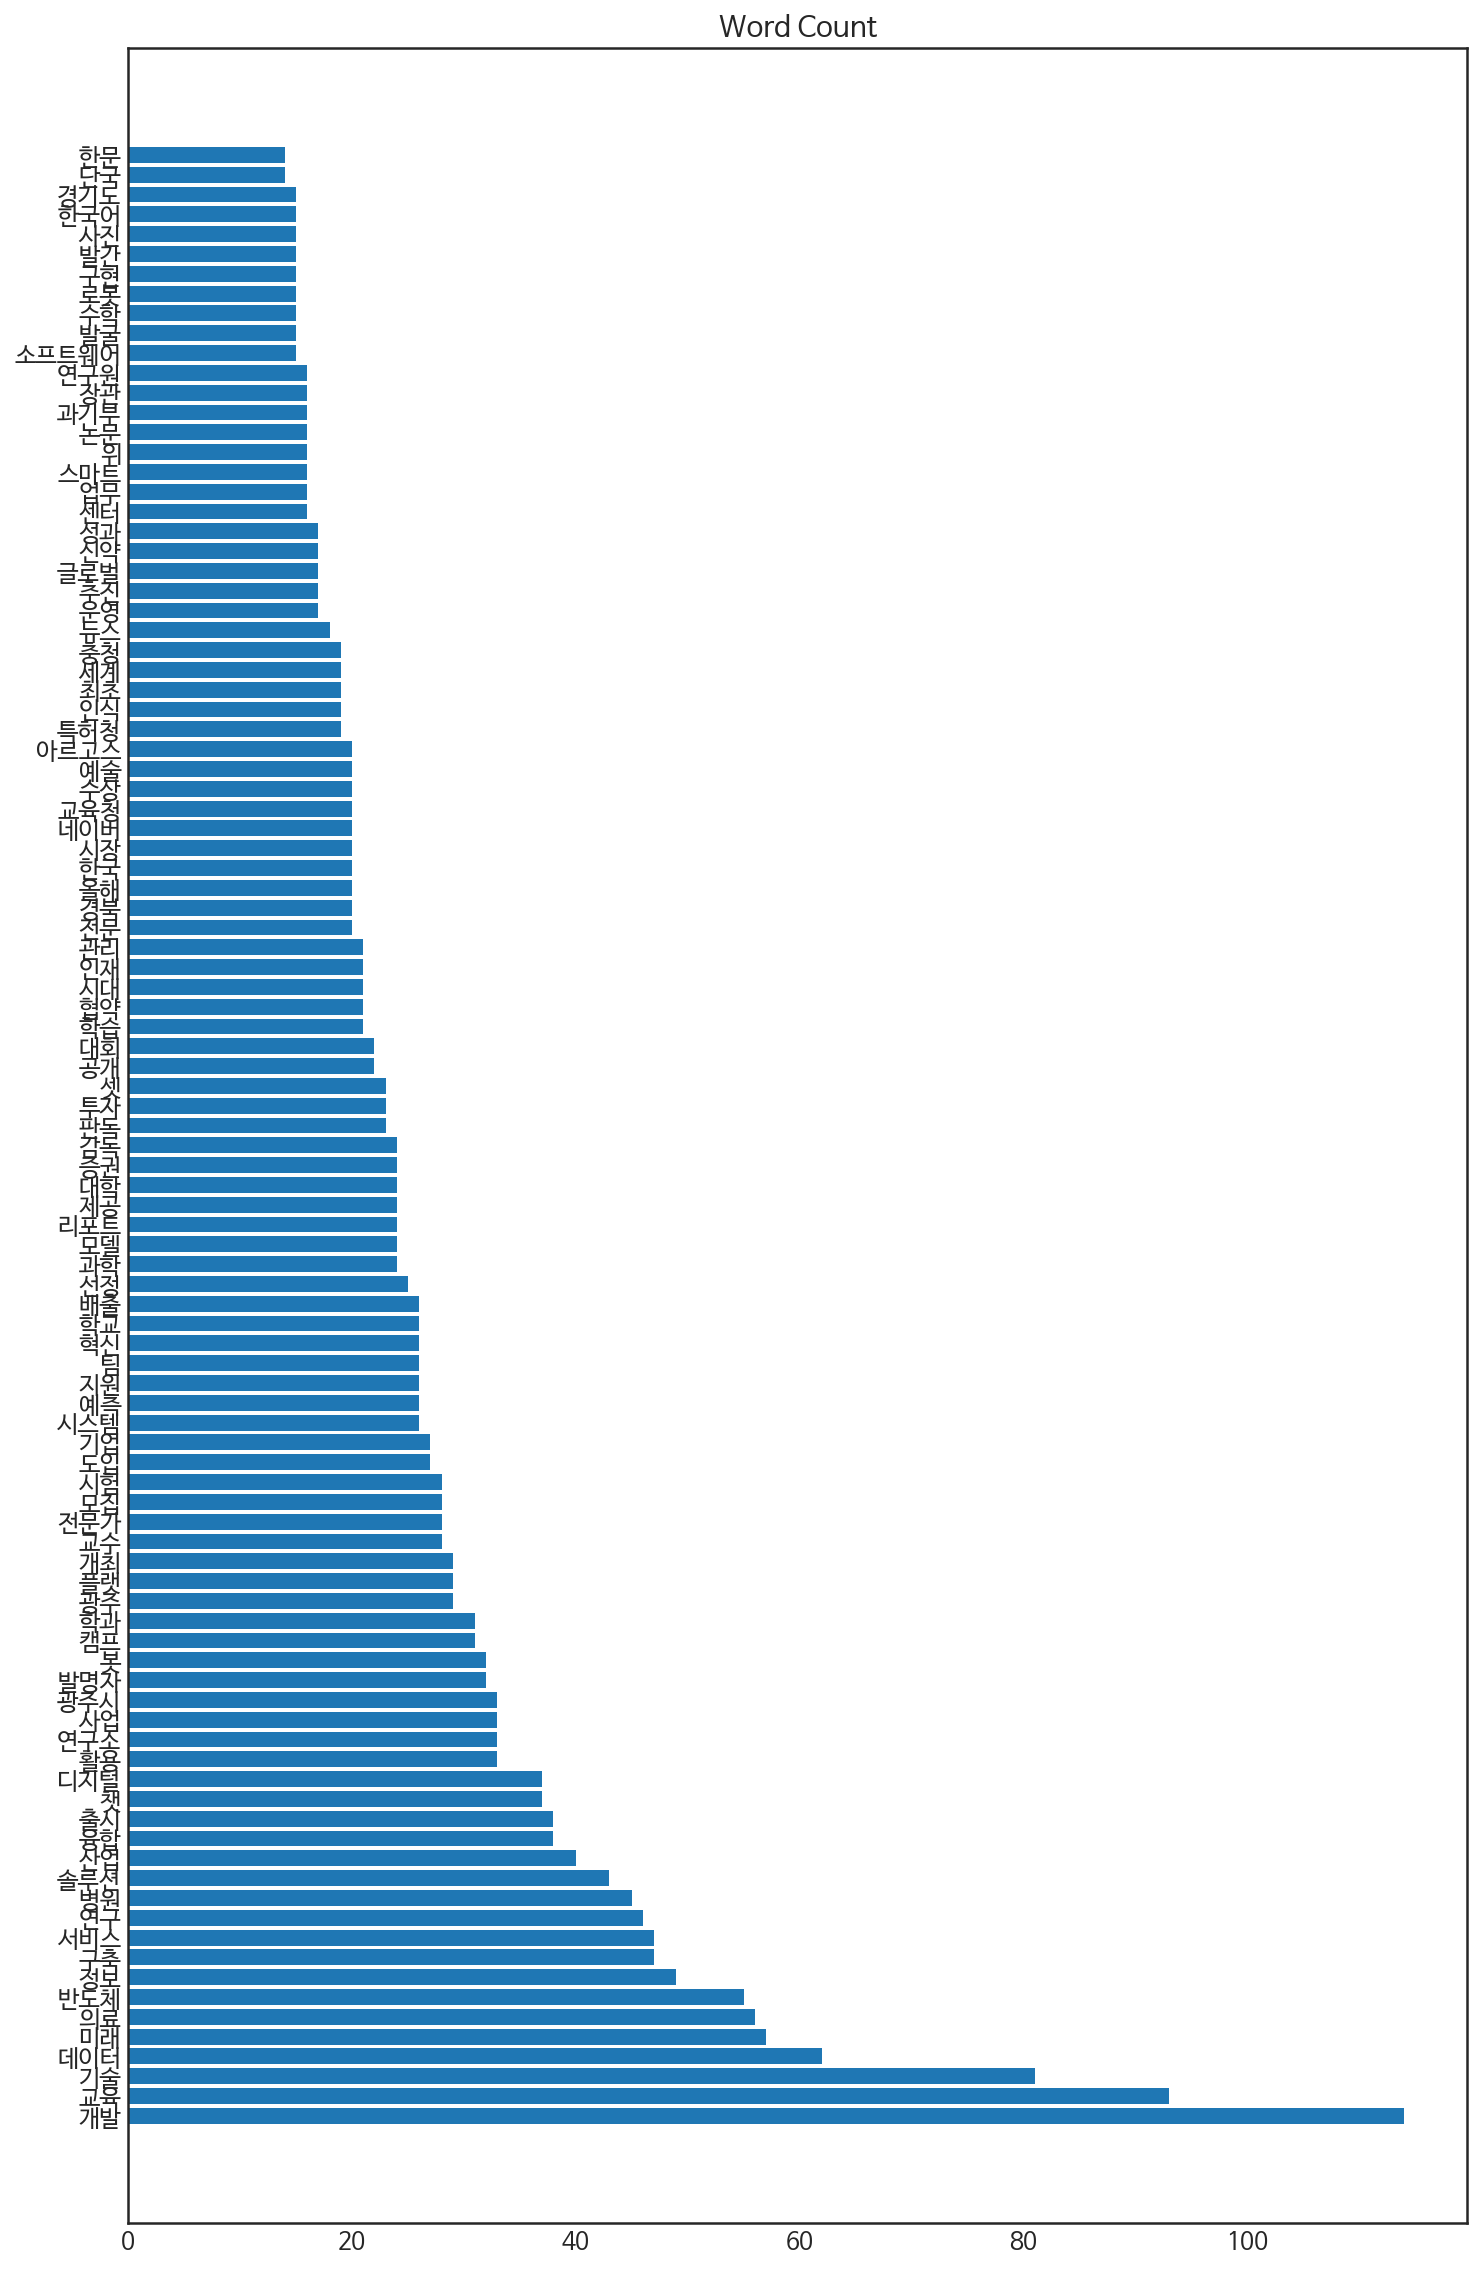

In [36]:
import numpy as np

plt.rcParams['font.size'] = 12

y_pos = np.arange(len(top_news_nouns))

plt.figure(figsize = (12, 20))
plt.barh(y_pos, top_news_nouns.values())
plt.title('Word Count')
plt.yticks(y_pos, top_news_nouns.keys())
plt.show() 

### 트리맵 시각화

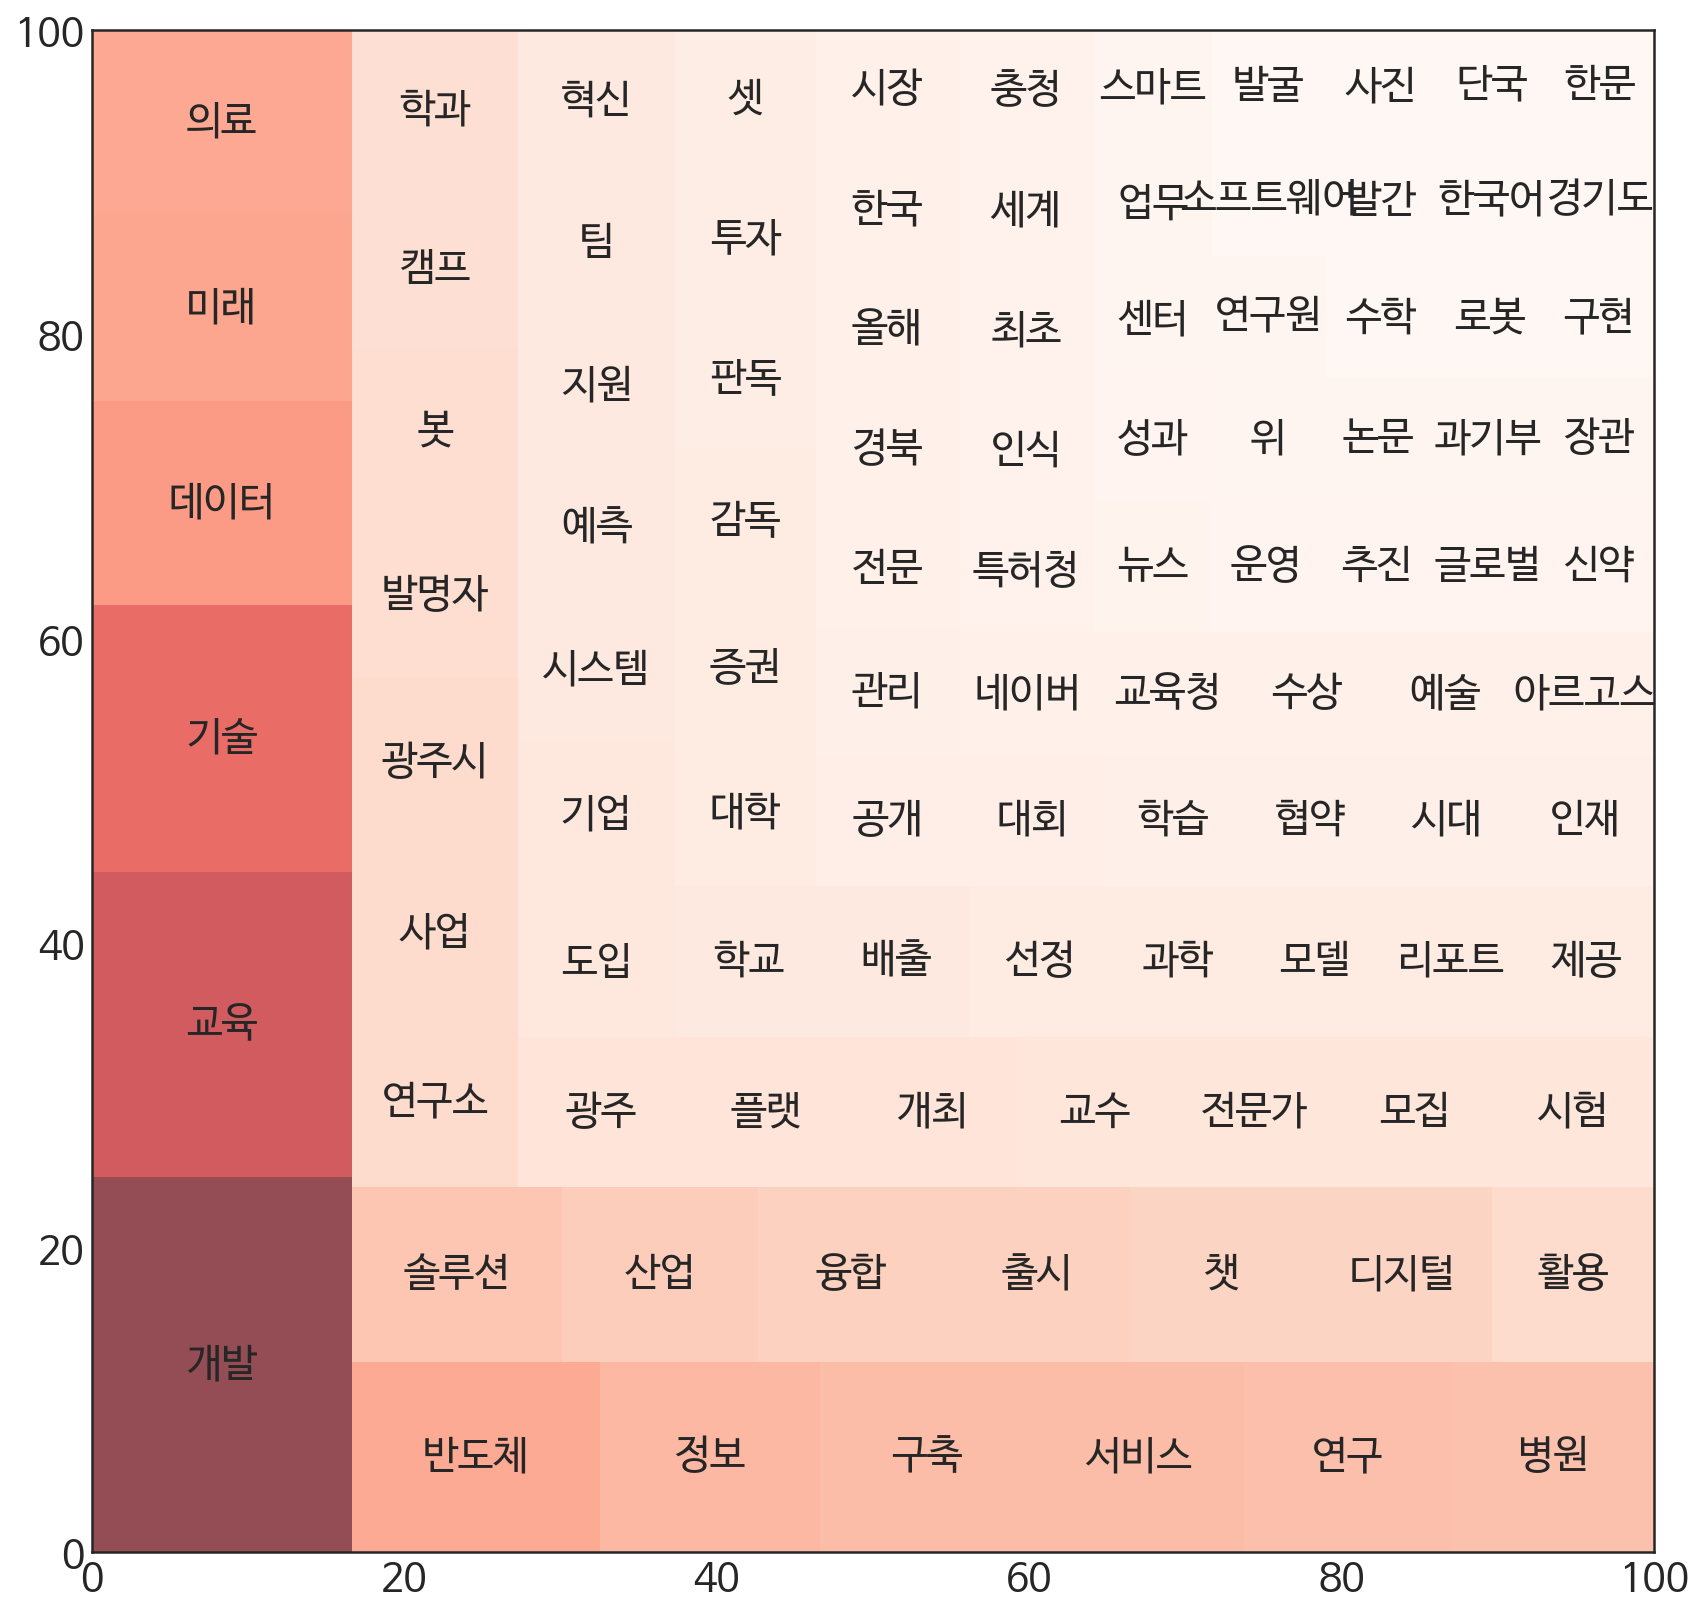

In [39]:
plt.rcParams['figure.figsize'] = (14,14)
plt.rcParams['font.size'] = 20

norm = mpl.colors.Normalize(vmin = min(top_news_nouns.values()),
                            vmax = max(top_news_nouns.values()))

colors = [mpl.cm.Reds(norm(value)) for value in top_news_nouns.values()]

squarify.plot(label = top_news_nouns.keys(),
              sizes = top_news_nouns.values(),
              color = colors,
              alpha = .7)

### 워드클라우드 시각화

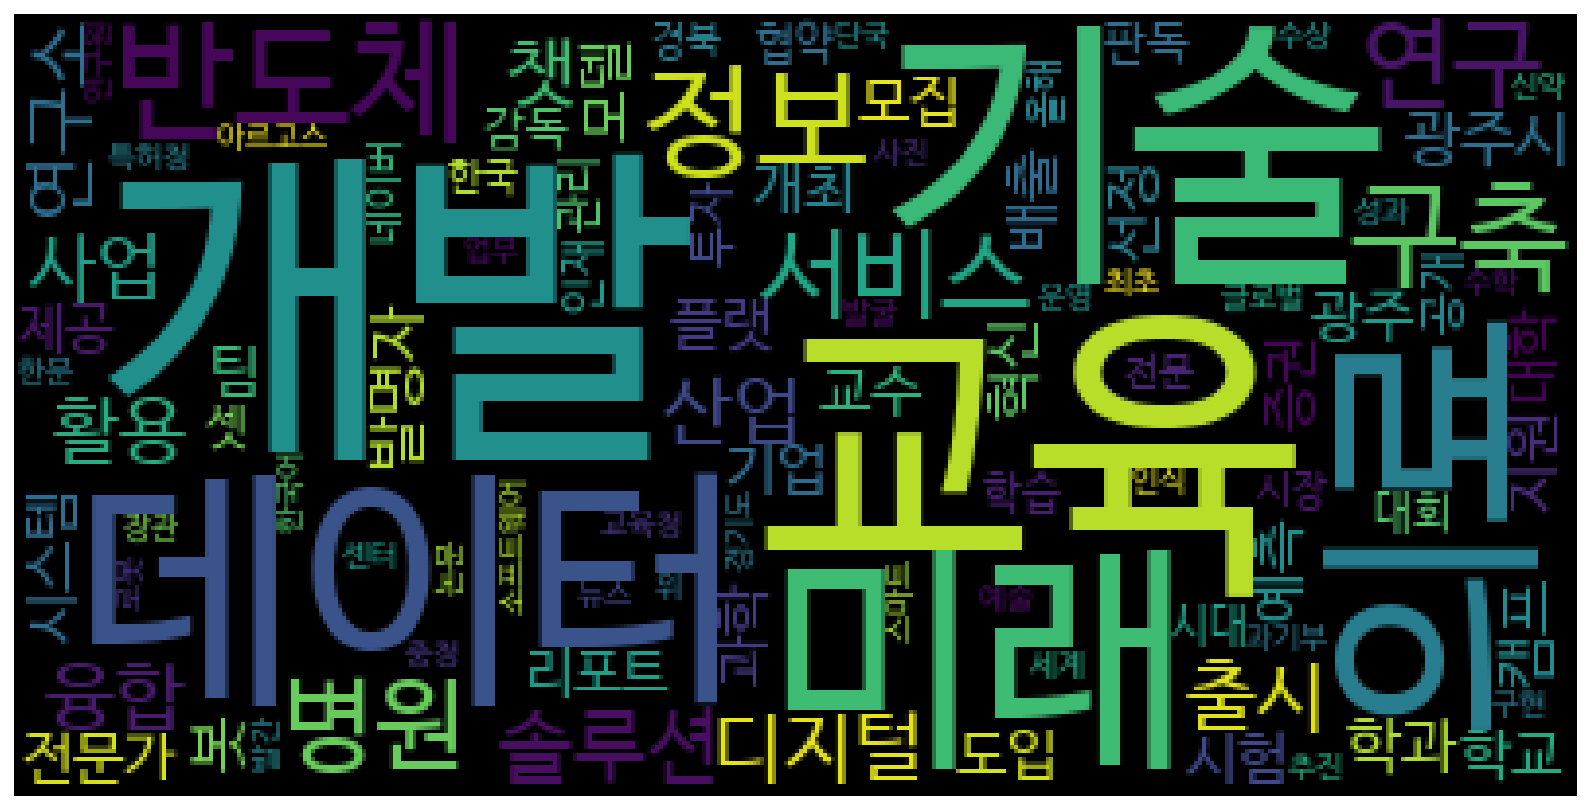

In [40]:
wc = WordCloud(background_color = 'black', font_path = './font/NanumBarunGothic.ttf')
wc.generate_from_frequencies(top_news_nouns)

figure = plt.figure(figsize = (14,14))
ax = figure.add_subplot(1,1,1)
ax.axis('off')
ax.imshow(wc)
plt.show()

## 네이버 블로그 키워드 분석

### 네이버 블로그 검색 API

### 형태소 분석을 이용한 명사 추출


### 단어 빈도수 측정

### 단어 빈도 시각화

### 트리맵 시각화

### 워드클라우드 시각화